# Assay and run directory

In [1]:
assay_name = "datasets/drd2_filtered.csv"
rundir = "results/lstm_hc/drd2_filtered"
pca_components = 50
kmeans = True 

results/test/lstm_hc/CHEMBL3888429_cleaned/ecfp4_range_physchem_maxsim_ecfp6/2022-03-17_13:33:05

# Analysis

In [2]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP, MolMR


font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 50,
    'text.usetex': False,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
def data_split(dataset):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints

    df = pd.read_csv(dataset)
    df['label'] = df['value']>7.5
    df['ecfp'] = ecfp4(df.smiles)
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=0)
    X1 = np.array(list(df_train['ecfp']))
    X2 = np.array(list(df_test['ecfp']))
    y1 = np.array(list(df_train['label']))
    y2 = np.array(list(df_test['label']))
      
    
    # train classifiers and store them in dictionary
    
    clf = RandomForestClassifier( 
        n_estimators=100, n_jobs=1, random_state=0)
    clf.fit(X1, y1)
    return clf.predict_proba(X2[np.where(y2==1)[0], :])[:, 1], list(df_test.smiles), list(df_test.label), clf


In [3]:
scores_test, smiles_test, activities_test, clf = data_split(assay_name)

In [4]:
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []
smiles_trajectories = []

l = [ 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7',
     'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7',
     'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7',
     'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7',
     'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7']


EPOCHS = [0, 10, 20]

for directory in l:
    smiles = []
    scores = []
    trajectories = [[] for i in range(len(EPOCHS))]
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(os.path.join(rundir, directory, result_dir, 'results.json'), 'r') as f:
                results = json.load(f)
                smiles.extend([row['smiles'] for row in results['statistics']][-1])
                scores.extend([row['preds']['scores'] for row in results['statistics']][-1])
                #trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                for j, epoch in enumerate(EPOCHS):
                    trajectories[j].extend([row['smiles'] for row in results['statistics']][epoch])
                average_trajectories = np.array([np.array(row['preds']['scores']) for row in results['statistics']])

                
        except:
            pass
    if len(smiles)>0:
        runs.append(directory)
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)
        smiles_trajectories.append(trajectories)

In [5]:
rundir = "results_memory_RL/lstm_hc/drd2_filtered/"
l = ['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7']

for directory in l:
    smiles = []
    scores = []
    trajectories = []
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(os.path.join(rundir, directory, result_dir, 'results.json'), 'r') as f:
                results = json.load(f)
                smiles.extend([row['smiles'] for row in results['statistics']][-1])
                scores.extend([row['preds']['scores'] for row in results['statistics']][-1])
                #trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                trajectories.append(np.array([np.mean(row['preds']['scores']) for row in results['statistics']]))
                average_trajectories = np.array([np.array(row['preds']['scores']) for row in results['statistics']])
        except:
            pass
    if len(smiles)>0:
        runs.append('counts_beta_ MemoryRL')
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)

In [6]:
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i])==1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)


In [7]:
X = np.array(actives + inactives)
#clustering = DBSCAN(eps=0.25, min_samples=1, metric='jaccard', p=1).fit(X)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_

In [8]:
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)

In [9]:
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [10]:
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)
    

In [11]:
pca = PCA(n_components=2).fit(np.concatenate((fps_inactive_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [12]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [13]:
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [14]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

In [15]:
# Parameters for drawing an ellipse around the main cluster
quant=0.1
n=80
t = np.linspace(0,2*np.pi,n)
l = 1.4 # Factor for considering only the generated structures that are far from the main cluster

In [16]:
distant_smiles_dict = {}
for i, run in enumerate(runs):
    index = runs.index(run)
    smiles_generated = smiles_list[i]
    pca_gen = pca_generated[index]
    [x_min,x_max] = [np.quantile(pca_gen[:,0:1], quant),np.quantile(pca_gen[:,0:1], 1.0-quant)]
    [y_min,y_max] = [np.quantile(pca_gen[:,1:2], quant),np.quantile(pca_gen[:,1:2], 1.0-quant)]
    center_x = np.mean([x_max,x_min])
    center_y = np.mean([y_max,y_min])
    radius_x = 1.4*(x_max-x_min)
    radius_y = 1.4*(y_max-y_min)
    is_distant = [((x-center_x)**2/radius_x**2+(y-center_y)**2/radius_y**2 > 1.0) for x,y in zip(list(pca_gen[:,0:1].ravel()),list(pca_gen[:,1:2].ravel()))]
    is_distant_indexes =[i for i, x in enumerate(is_distant) if x]
    distant_smiles_dict[run] = [ smiles_generated[i] for i in is_distant_indexes]

In [17]:
pca_generated = []
entropies = []
clusters = []
    
pca = PCA(n_components=2).fit(np.concatenate((fps_active_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]    
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)  
    else:
        curr_clusters = [find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(len(np.where(np.array(curr_clusters)==i)[0])/len(curr_clusters))
    entropy = scipy.stats.entropy(probs)/ np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [18]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

In [19]:
# Parameters for drawing an ellipse around the main cluster
quant=0.1
n=80
t = np.linspace(0,2*np.pi,n)
l = 1.4 # Factor for considering only the generated structures that are far from the main cluster

['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7', 'counts_beta_ MemoryRL']
ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7
0
['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7', 'counts_beta_ MemoryRL']
ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7
1
['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range

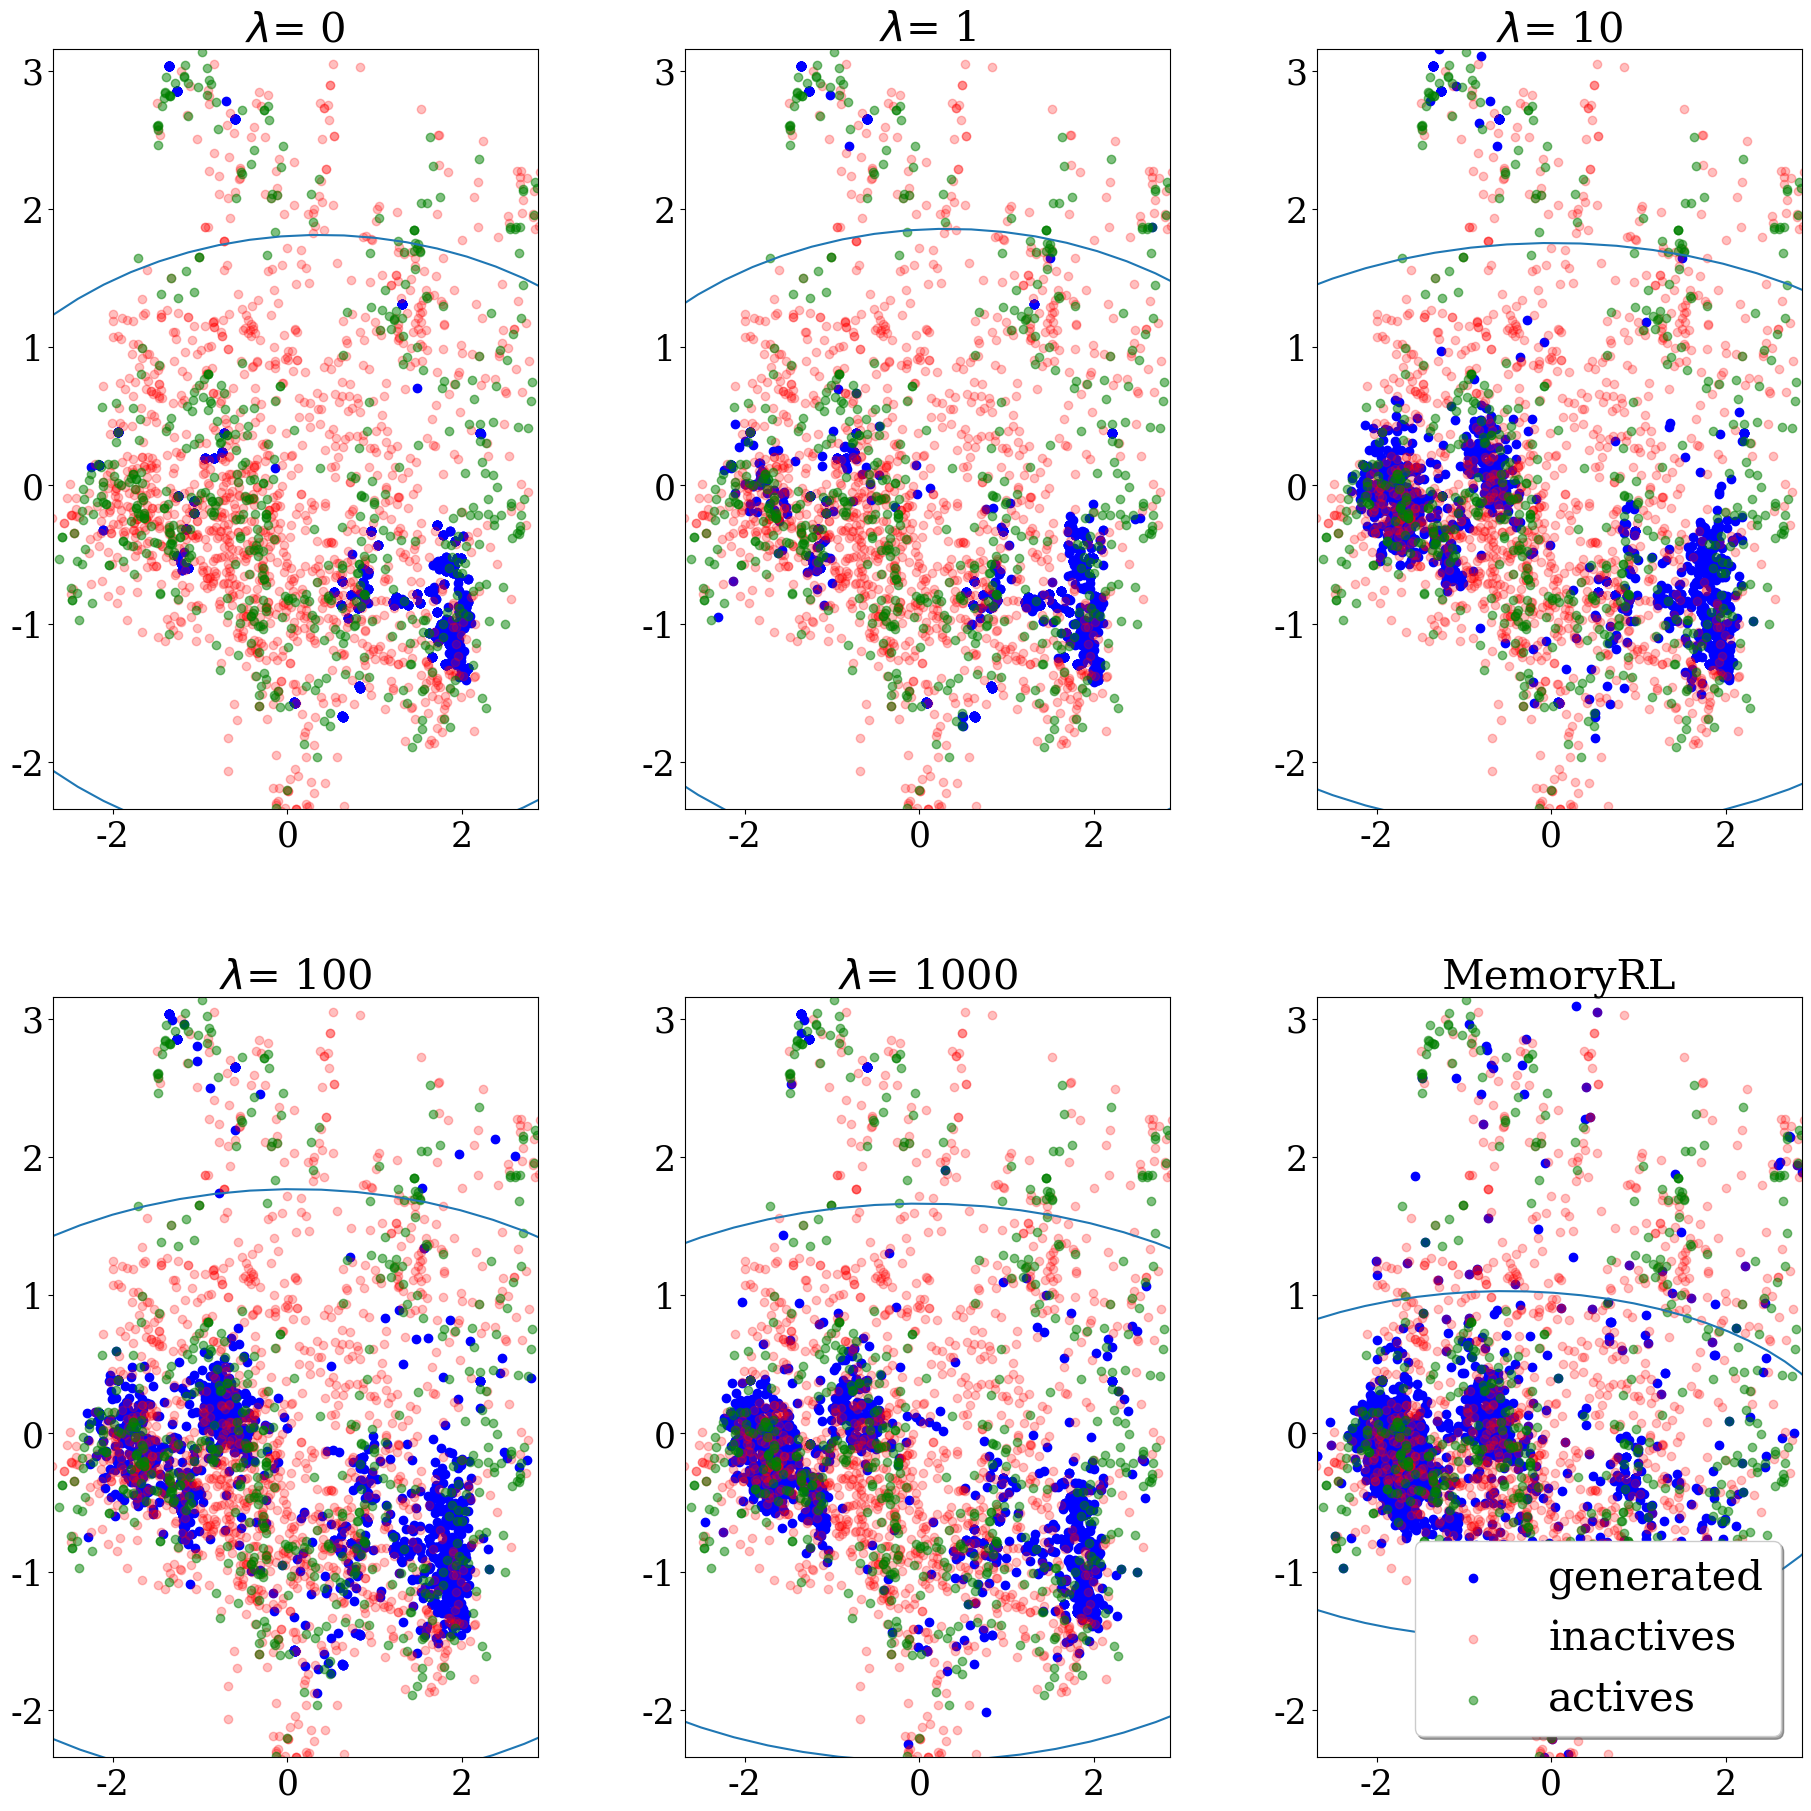

In [21]:
runs_to_display = runs
#runs_to_display = runs 
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs_to_display)/3)) , ncols=3)
#suptitle_tmp = 'AD : ' + runs_to_display[0].split('_beta_ ')[0] + '- Effect of beta'
#fig.suptitle(suptitle_tmp, fontsize=30)


for i, run in enumerate(runs_to_display):
    print(runs)
    print(run)
    index = runs.index(run)
    print(index)
    pca_gen = pca_generated[index]
    # For displaying the ellipse arounfd the main cluster
    [x_min,x_max] = [np.quantile(pca_gen[:,0:1], quant),np.quantile(pca_gen[:,0:1], 1.0-quant)]
    [y_min,y_max] = [np.quantile(pca_gen[:,1:2], quant),np.quantile(pca_gen[:,1:2], 1.0-quant)]
    center_x = np.mean([x_max,x_min])
    center_y = np.mean([y_max,y_min])
    radius_x = l*(x_max-x_min)
    radius_y = l*(y_max-y_min)
    #
    ax = axs.flatten()[i]
    try:
        run_title_tmp = run.split("_")[7]
        run_title = "$\lambda$=" + run_title_tmp
    except:
        pass
    if i==len(runs_to_display)-1:
        run_title = "MemoryRL"
    ax.set_title(run_title.replace('_', ' '), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c='b', label = 'generated', alpha=1)
    ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.5)
    # Proximity ellipse
    ax.plot( center_x+radius_x*np.cos(t) , center_y+radius_y*np.sin(t) )
    #
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    if i==len(runs_to_display)-1: 
        ax.legend(loc='lower right',
              ncol=1, fancybox=True, shadow=True, fontsize=30)
    
fig.tight_layout(pad=1.5)
plt.savefig('graphs/DRD2_merged_lambda_effect.pdf', dpi=300)   

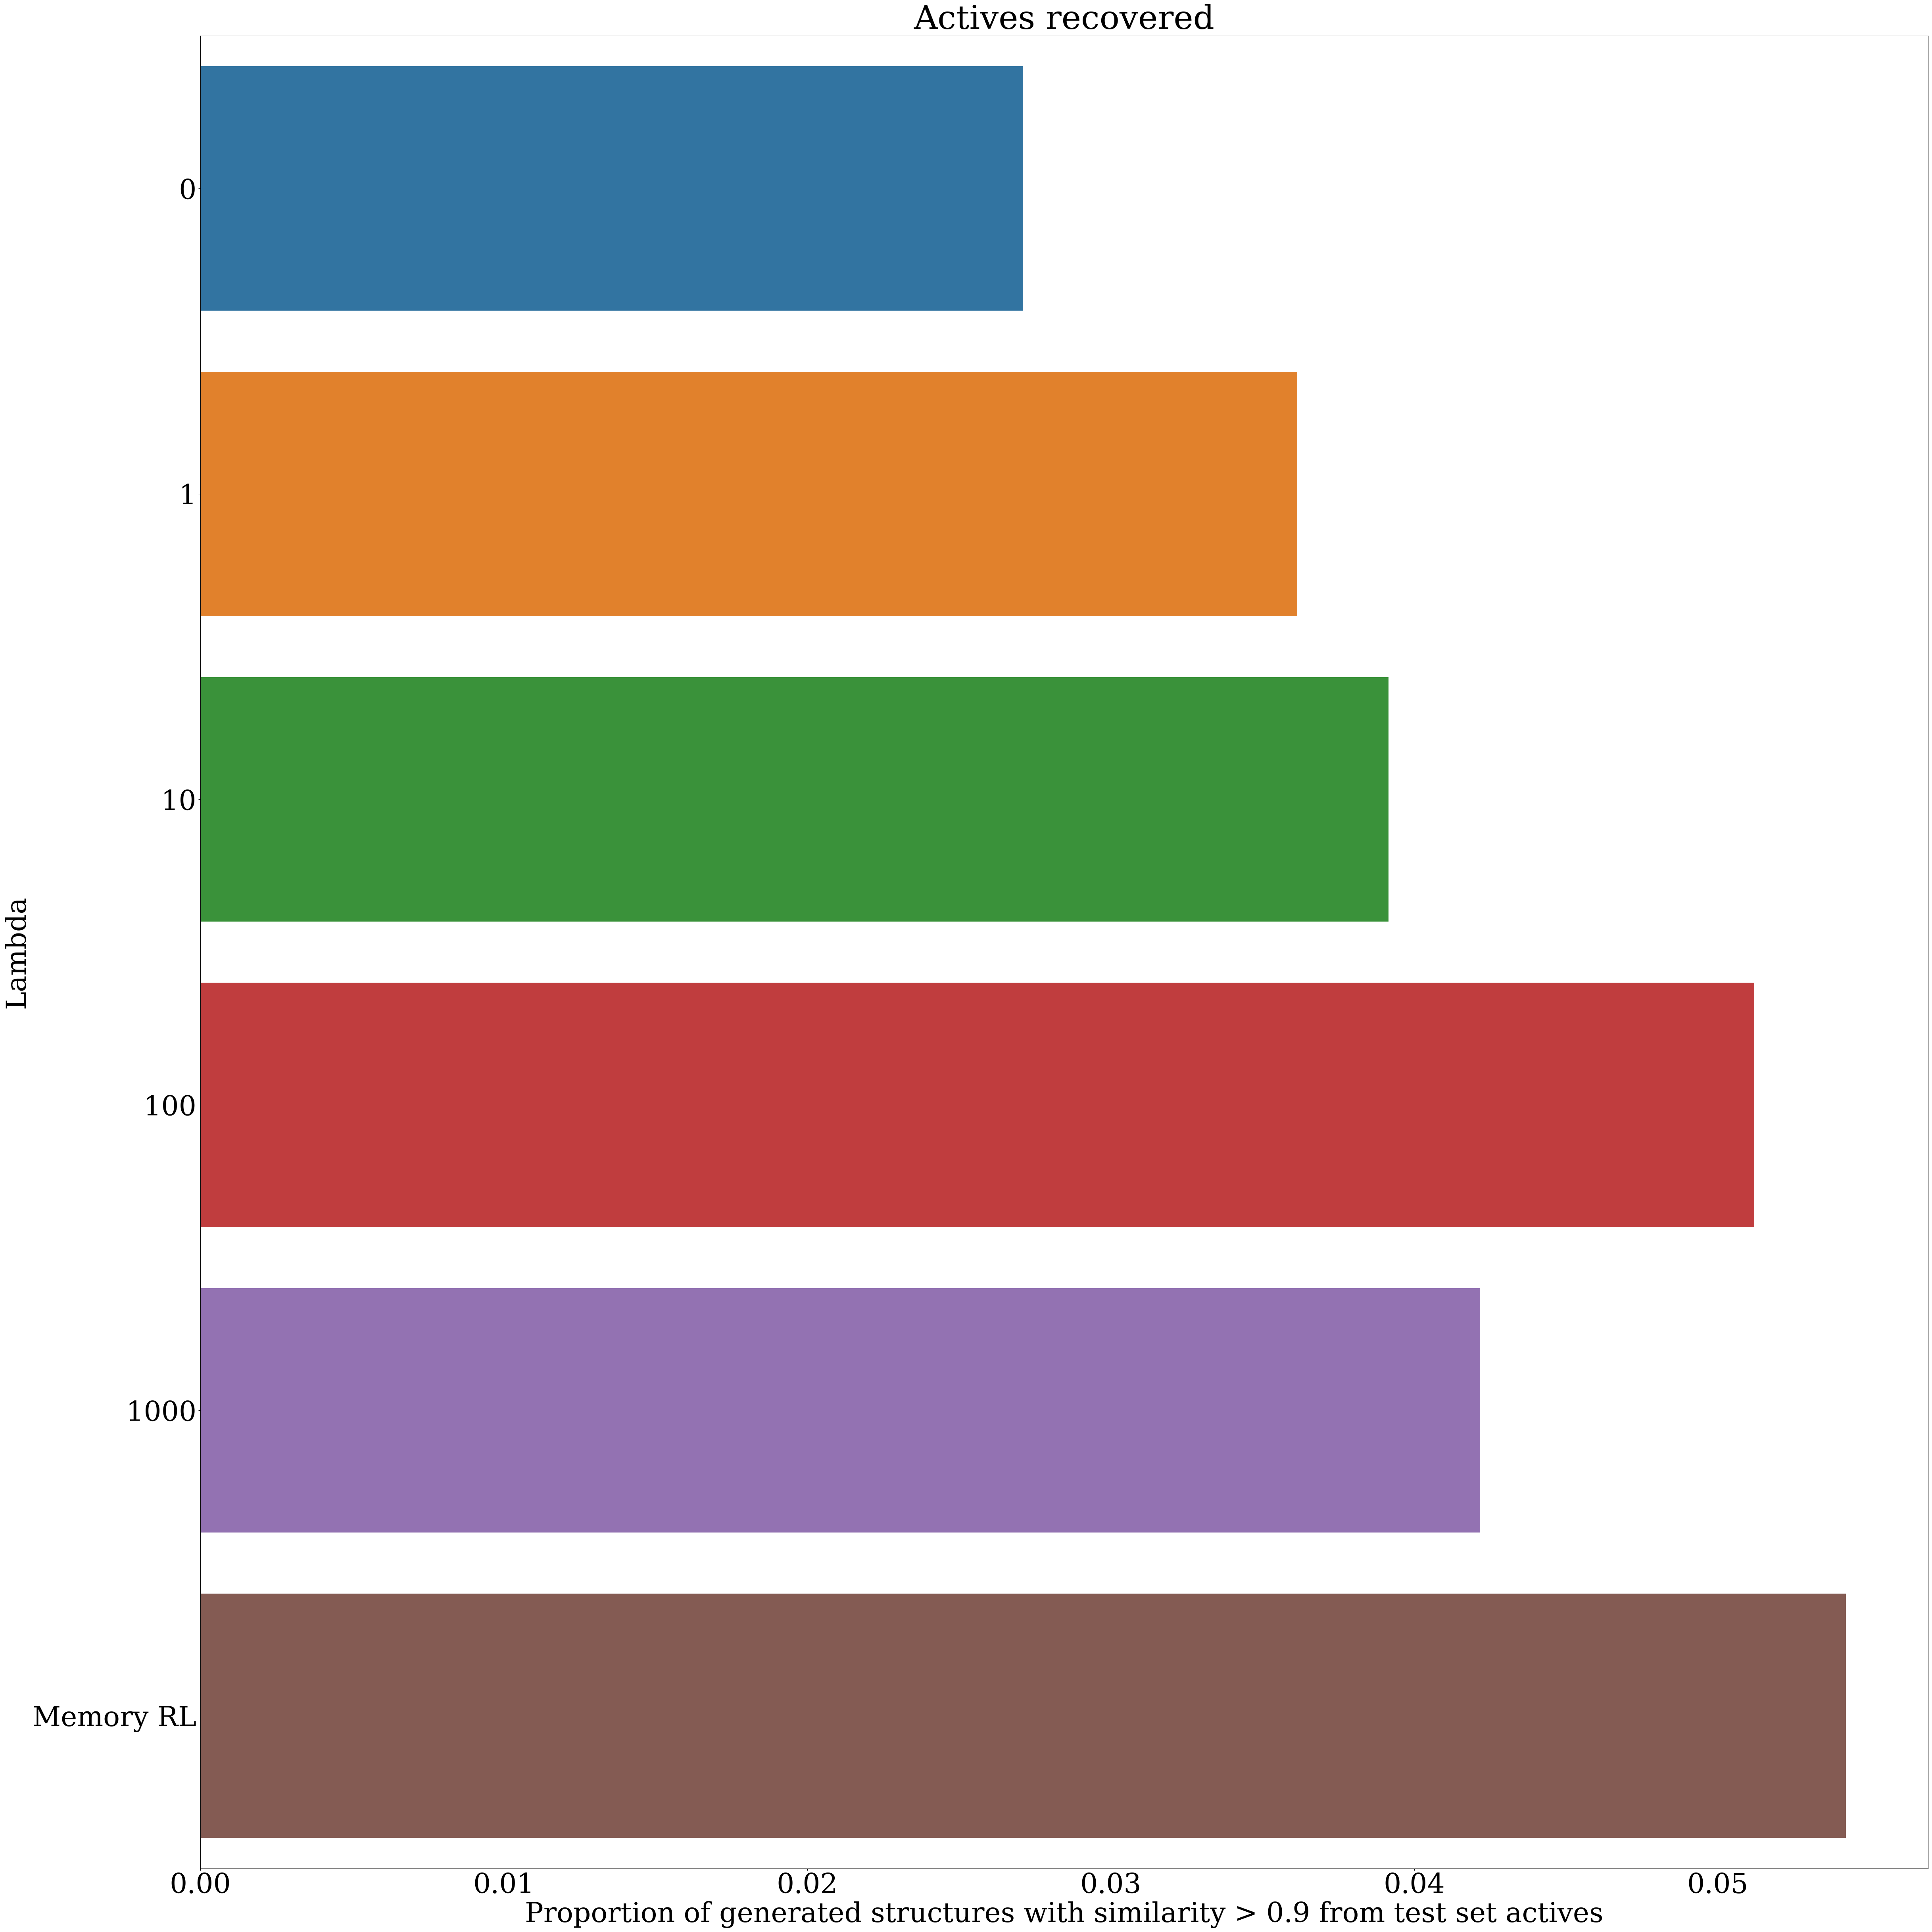

In [162]:

fig = plt.figure(figsize=(50, 50))
novel_recovered = []
titles = []


for i, run in enumerate(runs[:-1]):
    smiles_generated = smiles_list[i]
    fps_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated)>0.90:
            n_new += 1
    novel_recovered.append(n_new/len(predicted_actives))
    titles.append(run.split('_')[-3])
    

smiles_generated = smiles_list[-1]
fps_generated = []
for s in smiles_generated:
    mol = Chem.MolFromSmiles(s)
    fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
n_new = 0
for s in np.array(smiles_actives)[predicted_actives]:
    mol = Chem.MolFromSmiles(s)
    if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated)>0.90:
        n_new += 1
novel_recovered.append(n_new/len(predicted_actives))
titles.append('Memory RL')

display_df = pd.DataFrame(zip(titles, novel_recovered), columns =['Lambda', 'Proportion of generated structures with similarity > 0.9 from test set actives'])
chart = sns.barplot(display_df, y="Lambda", hue = 'Lambda', x="Proportion of generated structures with similarity > 0.9 from test set actives")

plt.title("Actives recovered")
plt.tight_layout()
plt.savefig('graphs/actives_recovered_0.9_drd2_merged.pdf', dpi=300 , bbox_inches = 'tight')
plt.show()


# Score evolution

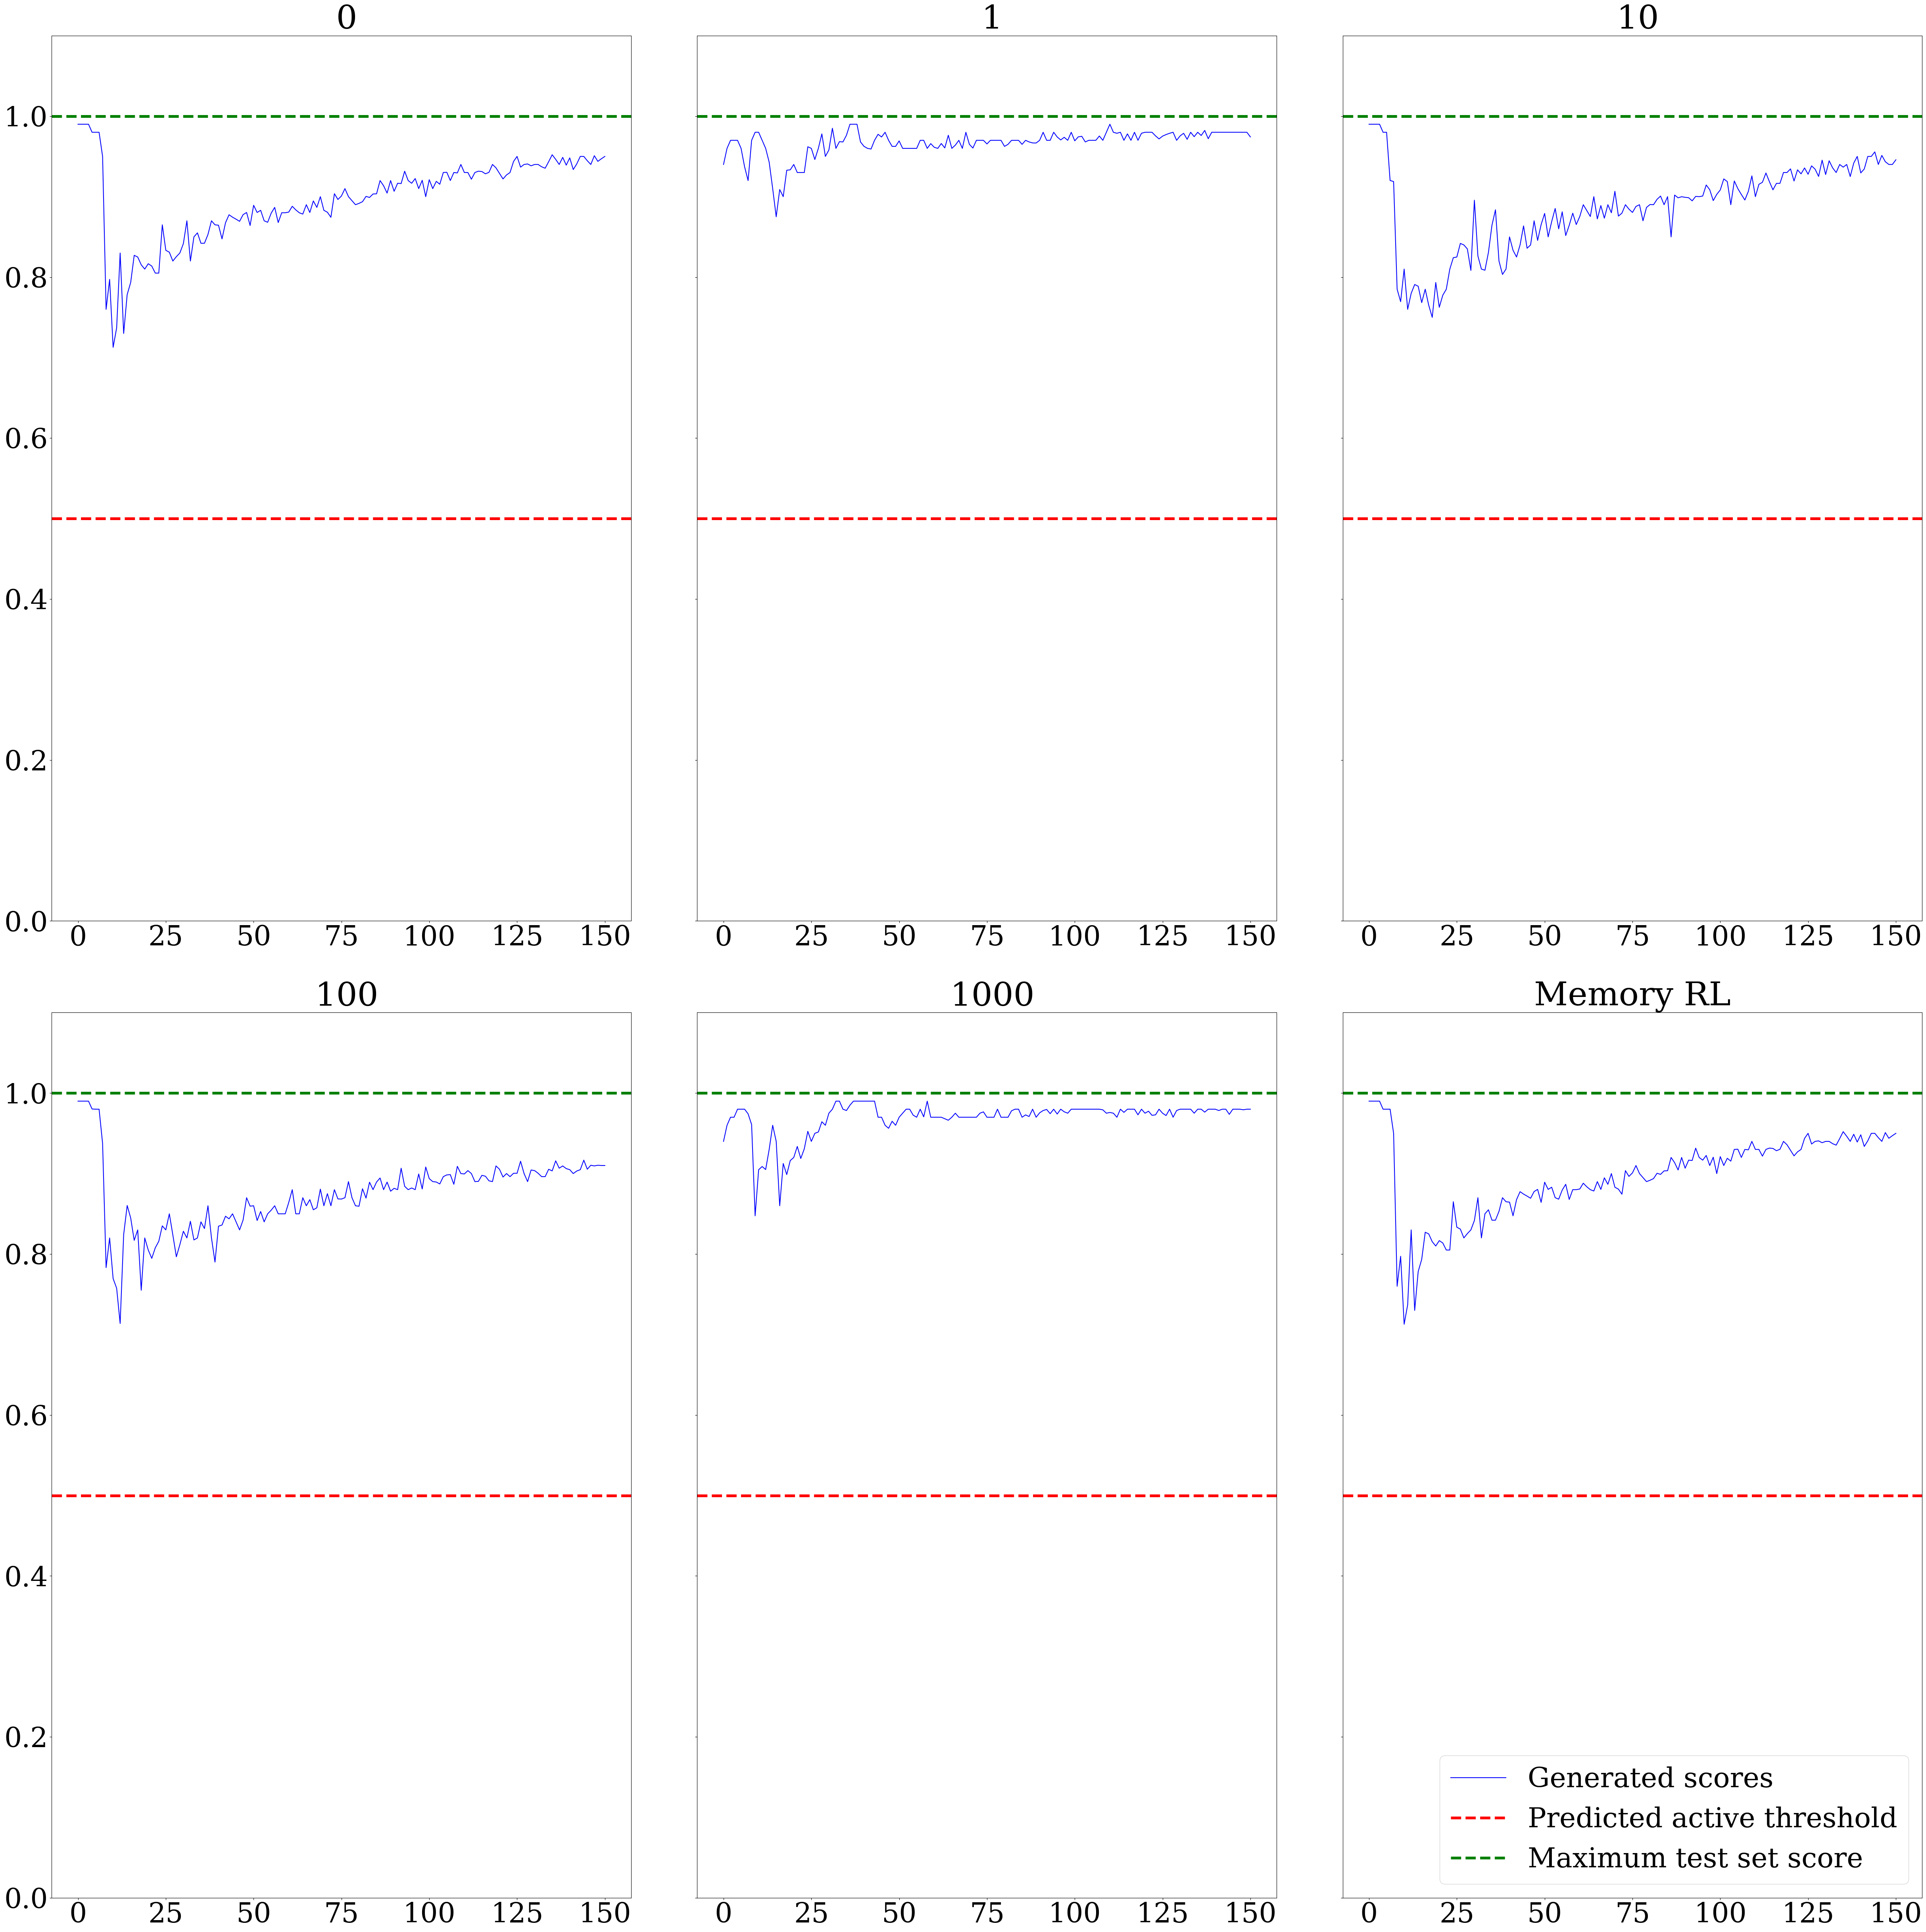

In [211]:
fig, axs = plt.subplots(figsize = (50, 50), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3, sharey=True)


titles = []
for run in runs[:-1]:
    titles.append(run.split('_')[-3])
titles.append("Memory RL")

for i, run in enumerate(runs):
    ax = axs.flatten()[i]
    ax.set_title(titles[i])
    scores = np.array(scores_trajectories[runs.index(run)])
    median = np.median(scores, 1)
    q25 = np.percentile(scores, 2.5, axis=1)
    q75 = np.percentile(scores, 97.5, axis=1)
    ax.plot(median, c='b', label='Generated scores')
    ax.axhline(y=0.5, linewidth=5, ls='--', color='r', label='Predicted active threshold')
    ax.axhline(y=np.max(scores_test), linewidth=5, ls='--', color='g', label='Maximum test set score')
ax.legend(loc=4)


plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig('graphs/aggregated_scores_drd2.pdf', dpi=300)